In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm, trange
from tabulate import tabulate
from datetime import datetime
import time
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

dataset_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/'
classes = os.listdir(dataset_path)
print(f'classes: {classes}')

classes: ['lung_aca', 'lung_scc', 'lung_n']


In [2]:
IMAGE_RESOLUTION = (224, 224)
BATCH_SIZE = 64
RANDOM_SEED = 42
VALID_SPLIT = 0.2
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(IMAGE_RESOLUTION),  # Resize images
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=means, std=stds)  # Normalize
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

generator = torch.Generator().manual_seed(RANDOM_SEED)
train_set, val_set = torch.utils.data.random_split(dataset, [1-VALID_SPLIT, VALID_SPLIT], generator=generator)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

img, label = dataset[10]
print(f'Image Size: {img.shape}')
print(f'Training Set: {len(train_set)}, Valid Set: {len(val_set)}, Number of Batches: {len(train_loader)}')

Image Size: torch.Size([3, 224, 224])
Training Set: 12000, Valid Set: 3000, Number of Batches: 188


In [3]:
HIDDEN_LAYERS = 3
LEARNING_RATE = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device: {device}')

# Creating a CNN class
class Net(nn.Module):
    """ A implementation of the ZFNet architecture from the paper 'Visualizing and 
        Understanding Convolutional Networks' by Zeiler and Fergus"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, padding_mode='reflect') 
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=2, padding_mode='reflect')
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, padding_mode='reflect')
        self.fc6 = nn.Linear(9216,4096)
        self.fc7 = nn.Linear(4096,4096)
        self.fc8 = nn.Linear(4096,3)
        self.pool1 = nn.MaxPool2d(3,stride=2)
        self.pool2 = nn.MaxPool2d(3,stride=2)
        self.drop = nn.Dropout(0.5)
        self.drop = nn.Dropout(0.5)
        self.lrn = nn.LocalResponseNorm(size=5,alpha=10e-4,beta=0.75,k=2.0)

    def forward(self, x):
        x = self.lrn(self.pool1(F.relu(self.conv1(x))))
        x = self.lrn(self.pool2(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(F.relu(self.conv5(x)))
        x = x.view(-1,9216)
        x = F.relu(self.drop(self.fc6(x)))
        x = F.relu(self.drop(self.fc7(x)))
        x = self.fc8(x)
        return x
    
model = Net()
model = nn.DataParallel(model)
model = model.to(device=device)

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

using device: cuda


In [4]:
def train_network(n_epochs, optimizer, model, train_loader, valid_loader, loss_fn = nn.CrossEntropyLoss()):
    pbar = trange(n_epochs, desc='Epoch')
    loss_train_array = []
    loss_valid_array = []
    start_time = time.time()
    for i, epoch in enumerate(pbar):
        loss_train = 0.0
        model.train()
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            model = model.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        loss_valid = 0.0
        model.eval()
        
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                model = model.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0] 
                correct += int((predicted == labels).sum())
                loss = loss_fn(outputs, labels)
                loss_valid += loss.item()
            
        pbar.set_postfix({'train loss': loss_train/len(train_loader), 'valid loss': loss_valid/len(valid_loader), 'valid acc': f'{correct/total*100}%'}, refresh=True)
        print('|-------------------------------------------------------------------------------------------|')
        loss_train_array.append(loss_train/len(train_loader))
        loss_valid_array.append(loss_valid/len(valid_loader))
        
    end_time = time.time()
    model.eval()
    accuracies = []
    for name, loader in [("Training", train_loader), ("Validation", valid_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                model.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            print(f'{name} Accuracy: {correct/total*100:.1f}')
            accuracies.append(correct/total*100)
        
    return loss_train_array, loss_valid_array, accuracies, (end_time - start_time)
        

In [5]:
loss_train, loss_valid, accuracies, times = train_network(20, optimizer, model, train_loader, val_loader)

Epoch:   5%|▌         | 1/20 [01:17<24:40, 77.95s/it, train loss=0.576, valid loss=0.303, valid acc=87.43333333333332%]

|-------------------------------------------------------------------------------------------|


Epoch:  10%|█         | 2/20 [02:33<23:02, 76.82s/it, train loss=0.242, valid loss=0.187, valid acc=93.0%]             

|-------------------------------------------------------------------------------------------|


Epoch:  15%|█▌        | 3/20 [03:51<21:52, 77.20s/it, train loss=0.201, valid loss=0.271, valid acc=90.4%]

|-------------------------------------------------------------------------------------------|


Epoch:  20%|██        | 4/20 [05:07<20:28, 76.77s/it, train loss=0.189, valid loss=0.171, valid acc=93.30000000000001%]

|-------------------------------------------------------------------------------------------|


Epoch:  25%|██▌       | 5/20 [06:25<19:14, 76.99s/it, train loss=0.15, valid loss=0.146, valid acc=94.53333333333333%] 

|-------------------------------------------------------------------------------------------|


Epoch:  30%|███       | 6/20 [07:41<17:56, 76.87s/it, train loss=0.134, valid loss=0.208, valid acc=91.10000000000001%]

|-------------------------------------------------------------------------------------------|


Epoch:  35%|███▌      | 7/20 [09:00<16:45, 77.38s/it, train loss=0.127, valid loss=0.176, valid acc=93.76666666666667%]

|-------------------------------------------------------------------------------------------|


Epoch:  40%|████      | 8/20 [10:18<15:31, 77.64s/it, train loss=0.122, valid loss=0.136, valid acc=94.66666666666667%]

|-------------------------------------------------------------------------------------------|


Epoch:  45%|████▌     | 9/20 [11:35<14:13, 77.58s/it, train loss=0.0968, valid loss=0.221, valid acc=92.60000000000001%]

|-------------------------------------------------------------------------------------------|


Epoch:  50%|█████     | 10/20 [12:53<12:54, 77.46s/it, train loss=0.0964, valid loss=0.11, valid acc=96.39999999999999%]

|-------------------------------------------------------------------------------------------|


Epoch:  55%|█████▌    | 11/20 [14:11<11:39, 77.68s/it, train loss=0.0896, valid loss=0.128, valid acc=95.96666666666667%]

|-------------------------------------------------------------------------------------------|


Epoch:  60%|██████    | 12/20 [15:27<10:18, 77.37s/it, train loss=0.125, valid loss=0.13, valid acc=95.66666666666667%]  

|-------------------------------------------------------------------------------------------|


Epoch:  65%|██████▌   | 13/20 [16:43<08:58, 76.99s/it, train loss=0.0774, valid loss=0.102, valid acc=97.0%]           

|-------------------------------------------------------------------------------------------|


Epoch:  70%|███████   | 14/20 [17:59<07:39, 76.67s/it, train loss=0.0648, valid loss=0.156, valid acc=96.23333333333333%]

|-------------------------------------------------------------------------------------------|


Epoch:  75%|███████▌  | 15/20 [19:15<06:21, 76.38s/it, train loss=0.0712, valid loss=0.146, valid acc=97.06666666666666%]

|-------------------------------------------------------------------------------------------|


Epoch:  80%|████████  | 16/20 [20:31<05:05, 76.27s/it, train loss=0.0496, valid loss=0.108, valid acc=97.5%]             

|-------------------------------------------------------------------------------------------|


Epoch:  85%|████████▌ | 17/20 [21:48<03:48, 76.31s/it, train loss=0.0622, valid loss=0.117, valid acc=95.8%]

|-------------------------------------------------------------------------------------------|


Epoch:  90%|█████████ | 18/20 [23:05<02:33, 76.65s/it, train loss=0.0724, valid loss=0.103, valid acc=96.96666666666667%]

|-------------------------------------------------------------------------------------------|


Epoch:  95%|█████████▌| 19/20 [24:22<01:16, 76.68s/it, train loss=0.05, valid loss=0.103, valid acc=97.2%]               

|-------------------------------------------------------------------------------------------|


Epoch: 100%|██████████| 20/20 [25:38<00:00, 76.95s/it, train loss=0.0615, valid loss=0.17, valid acc=96.76666666666667%]

|-------------------------------------------------------------------------------------------|


Training Accuracy: 98.8
Validation Accuracy: 96.8


Text(0, 0.5, 'Loss')

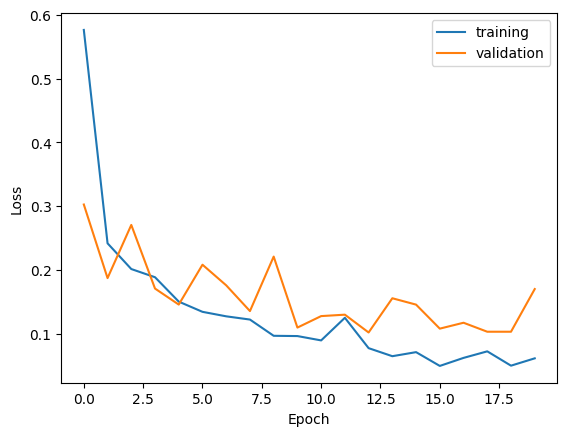

In [6]:
fig, ax = plt.subplots()
ax.plot(range(20), loss_train, label='training')
ax.plot(range(20), loss_valid, label='validation')
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [7]:
print(f'{times/60} minutes to train for 20 epochs')
print(f'training accuracy: {accuracies[0]}%')
print(f'validation accuracy: {accuracies[1]}%')

25.64839423497518 minutes to train for 20 epochs
training accuracy: 98.75%
validation accuracy: 96.76666666666667%
